# Project Introduction
The object of the project is to define business questions, apply data integration for business questions and generate a proper data analysis based on business questions.
In addition, FRM Customer segmentation, Cohort analysis, Market Basket analysis and Prediction on revenue will be conducted for more business insights and potential business decision recommendations.


---

Dataset Description <br>

This is a transnational dataset which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail.The company mainly sells unique all-occasion gifts. Many customers of the company are wholesalers.

The data was retrieved from Kaggle. Find the full detailed description from [here](https://www.kaggle.com/carrie1/ecommerce-data).

---



This project is insprired by both school curriculums in Business, Data Analytics, Machine Learning  and great notebook/resources online as following:


*   https://www.kaggle.com/yugagrawal95/rfm-analysis
*   https://www.kaggle.com/fszlnwr/customer-segmentation-rfm-cohort-analysis#Cohort-Analysis



# Table of Content

* Import Required Libraries
* Data Wrangling
* Business Analytics
* RFM Customer Segmentation
* Cohort Analysis
* Market Basket Analysis
* Revenue Prediction

# Load Library & Dataset

In [ ]:
import os
from functools import reduce

# Data Processing
import numpy as np
import pandas as pd
import datetime as dt

# Data Visualizing
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.express as px

# Data Clustering
from mlxtend.frequent_patterns import apriori # Data pattern exploration
from mlxtend.frequent_patterns import association_rules # Association rules conversion

# Data Modeling
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.cluster import KMeans
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.metrics import explained_variance_score, r2_score

# Math
from scipy import stats  # Computing the t and p values using scipy 

# Warning Removal
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)

: 

In [90]:
pwd = os.getcwd()
file_path = pwd + '/data.csv'
df = pd.read_csv(file_path, encoding = 'unicode_escape')
# https://stackoverflow.com/questions/22216076/unicodedecodeerror-utf8-codec-cant-decode-byte-0xa5-in-position-0-invalid-s

In [3]:
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,12/9/2011 12:50,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,12/9/2011 12:50,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,12/9/2011 12:50,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,12/9/2011 12:50,4.15,12680.0,France


# Data Wrangling

**General data exploration.**

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


By examining the data types and number of valid values in columns, data types for InvoiceDate and CustomerID should be altered to timestamp and integer.

In [5]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


There are negative Quantity and UnitPrice, indicating that there are customers returning products which may cause profit loss. We will discover more in business questions.

**Duplicated records.**

In [6]:
df.duplicated().sum()

5268

In [7]:
# drop duplicated records
df.drop_duplicates(inplace = True)

**Missing values.**

Check missing values for columns.

In [8]:
df_info = pd.DataFrame(df.isnull().sum().sort_values())
df_info.columns = ['Null value']
df_info['Null value %'] = df_info.values/df.shape[0] * 100
df_info

,Null value,Null value %
InvoiceNo,0,0.000000
StockCode,0,0.000000
Quantity,0,0.000000
InvoiceDate,0,0.000000
UnitPrice,0,0.000000
Country,0,0.000000
Description,1454,0.270945
CustomerID,135037,25.163377


Check missing values for rows.

In [9]:
df[df.isnull().any(axis=1)]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
622,536414,22139,NaN,56,12/1/2010 11:52,0.00,NaN,United Kingdom
1443,536544,21773,DECORATIVE ROSE BATHROOM BOTTLE,1,12/1/2010 14:32,2.51,NaN,United Kingdom
1444,536544,21774,DECORATIVE CATS BATHROOM BOTTLE,2,12/1/2010 14:32,2.51,NaN,United Kingdom
1445,536544,21786,POLKADOT RAIN HAT,4,12/1/2010 14:32,0.85,NaN,United Kingdom
1446,536544,21787,RAIN PONCHO RETROSPOT,2,12/1/2010 14:32,1.66,NaN,United Kingdom
...,...,...,...,...,...,...,...,...
541536,581498,85099B,JUMBO BAG RED RETROSPOT,5,12/9/2011 10:26,4.13,NaN,United Kingdom
541537,581498,85099C,JUMBO BAG BAROQUE BLACK WHITE,4,12/9/2011 10:26,4.13,NaN,United Kingdom
541538,581498,85150,LADIES & GENTLEMEN METAL SIGN,1,12/9/2011 10:26,4.96,NaN,United Kingdom
541539,581498,85174,S/4 CACTI CANDLES,1,12/9/2011 10:26,10.79,NaN,United Kingdom


There are two columns with missing values, Description and Cusomter ID. I apply different approaches, either imputing or removing missing values, for the two columns.

Column **Description**:<br>
Each description is uniquely identified by a StockCode, therefore, I fill missing descriptions with ones under the same cateogry (StockCode).

In [10]:
# looking for mode in a columns after aggregation.
# https://learnxinyminutes.com/docs/python/
def description_filler(df):
  try:
    return df.mode().iloc[0]
  except Exception:
    return 'Description not found'

In [11]:
df[['StockCode', 'Description']] = df[['StockCode', 'Description']].fillna(
    df[['StockCode', 'Description']].groupby('StockCode').transform(description_filler)) #apply(description_filler).
# https://towardsdatascience.com/difference-between-apply-and-transform-in-pandas-242e5cf32705

print("Number of missing description: ",df['Description'].isnull().sum())
print("Number of unfounded description:",df['Description'].str.contains('Description not found').sum())

Number of missing description:  0
Number of unfounded description: 112


I also observe the inconsistency of cases, hence, I convert all description contents to lower case for ease of reading.

In [12]:
df['Description'] = df['Description'].str.lower()

Column **CustomerID**:<br>
There are over 25% values in CustomerID missing. Moreover, I have no additional means to retrieve the correct information for customer ID and add to the dataframe. Thus, I remove all missing values for the ease of analysis.

In [13]:
# remove records based on the missing values in columns CustomerID
df.dropna(inplace=True,subset = ['CustomerID'])

Besides CustomerId and Description, other columns need data integration for better consistency.

Column **InvoiceNo**:<br>
The invoice number is to idenfity inoivces.
The standard format for Invoice number should be 6-digit integers. By going through the data, some invoice numbers start with 'C', indicating that the invoice was cancelled. <br>
However, cancellations can be identified by *negative* values in column Quantity. 'C' in invoice number, consequently, should be removed for consistency.

In [14]:
# if invoice number contains C, remove C
df['InvoiceNo'] = df['InvoiceNo'].apply(lambda x: x.replace('C','') if 'C' in x else x)

Column **StockCode**:<br>
The general format for stock code is 5-digit integers with or without a letter. Similar to Invoice number, stock code has special cases. Some stock codes contain special codes that intend to identify vairous types of transactions, without 5-digit integers.<br>

I identify all letters present in stock code and then link the letters to descriptions, since, as stated above, stock code and description are uniquely matched.

In [15]:
#https://stackoverflow.com/questions/3617797/regex-to-match-only-letters
stock_special_code = df[df['StockCode'].str.contains('^[a-zA-Z]+',regex=True)]['StockCode'].unique().tolist()
stock_special_code

['POST', 'D', 'C2', 'M', 'BANK CHARGES', 'PADS', 'DOT', 'CRUK']

In [16]:
special_code_description = []
for x in stock_special_code:
  des = df.query(f"StockCode == '{x}'")['Description'].unique()[0]
  special_code_description.append(des)
special_code_description

['postage',
 'discount',
 'carriage',
 'manual',
 'bank charges',
 'pads to match all cushions',
 'dotcom postage',
 'cruk commission']

In [17]:
stock_code_info = pd.DataFrame(list(zip(stock_special_code,special_code_description)),
                               columns = ['Special Code','Description'])
stock_code_info

,Special Code,Description
0,POST,postage
1,D,discount
2,C2,carriage
3,M,manual
4,BANK CHARGES,bank charges
5,PADS,pads to match all cushions
6,DOT,dotcom postage
7,CRUK,cruk commission


Column **Quantity**:<br>
Based on the observation, majority of invoices land between [-20000,20000] and around 0. <br> 
There are outliers below and above the range, therefore, I remove outliers.


In [18]:
df['Quantity'].describe()

count    401604.000000
mean         12.183273
std         250.283037
min      -80995.000000
25%           2.000000
50%           5.000000
75%          12.000000
max       80995.000000
Name: Quantity, dtype: float64

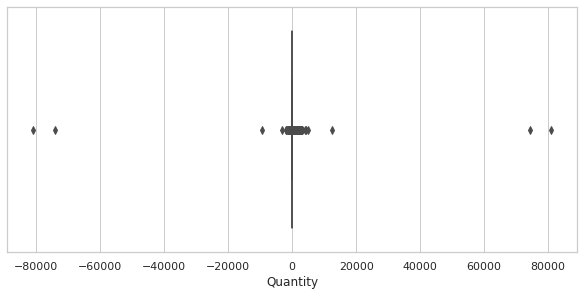

In [19]:
# plot quantity via a box plot

sns.set_theme(style='whitegrid')

plt.figure(figsize = (8,4), constrained_layout = True)
sns.boxplot(df['Quantity'])

In [20]:
# remove outliers
df = df[(df['Quantity'] < 20000) & (df['Quantity'] > -20000)]

Column **InvoiceDate**: <br>

The format of invoice date is correct, however, datatype should be date/datetime, instead of object. In addition, I convert a single invoice date column into several sub-columns for the following anlaysis.

**To strictly analyze the data for the scale of 1 year(365days), I trim the date range to 2010-12-01 - 2011-12-01.**

In [21]:
# change data type for the column
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['Date'] = df['InvoiceDate'].dt.normalize()
df = df[df['Date'] < '2011-12-02']

In [22]:
# split InvoiceDate into sub-columns including year, month, day, hour and day of week.
df['Year'] = df['InvoiceDate'].dt.year
df['Month'] = df['InvoiceDate'].dt.month
df['Day'] = df['InvoiceDate'].dt.day
df['Hour'] = df['InvoiceDate'].dt.hour
df['Dayofweek'] = df['InvoiceDate'].dt.dayofweek

# change day of week encodings to day names
df['Dayofweek'] = df['Dayofweek'].map( # map is faster than replace
    {0:'1_Monday',
     1:'2_Tuesday',
     2:'3_Wednesday',
     3:'4_Thursday',
     4:'5_Friday',
     5:'6_Saturday',
     6:'7_Sunday'}
)

Column **UnitPrice**:<br>
Based on statistic summary, all values of unit price are equal or above 0, thus, the unit price does not require additional processing. <br>

Since the company is UK-based, I also assume the currency unit is in pound, thus, the unit for both unit price and revenue is pound. In addition to information from unit price and quantity, I am able to generate revenue for each invoice, which is the product of UnitPrice and Quantity.

In [23]:
df['UnitPrice'].describe()

count    386426.000000
mean          3.499309
std          71.046965
min           0.000000
25%           1.250000
50%           1.950000
75%           3.750000
max       38970.000000
Name: UnitPrice, dtype: float64

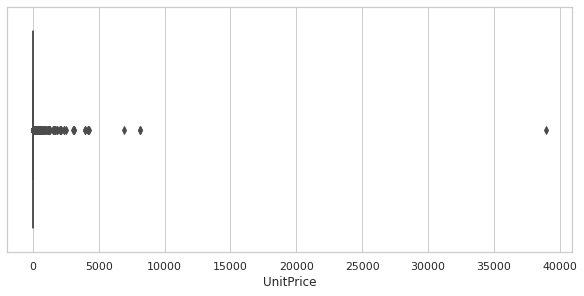

In [24]:
sns.set_theme(style = 'whitegrid')

plt.figure(figsize = (8,4), constrained_layout = True)
sns.boxplot(df['UnitPrice'])

In [25]:
# compute revenue and assign a new column called Revenue
df['Revenue'] = df['UnitPrice'] * df['Quantity']

---

In [26]:
df['CustomerID'] = df['CustomerID'].astype('int64')
df.head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Date,Year,Month,Day,Hour,Dayofweek,Revenue
0,536365,85123A,white hanging heart t-light holder,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,2010-12-01,2010,12,1,8,3_Wednesday,15.30
1,536365,71053,white metal lantern,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,2010-12-01,2010,12,1,8,3_Wednesday,20.34
2,536365,84406B,cream cupid hearts coat hanger,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,2010-12-01,2010,12,1,8,3_Wednesday,22.00
3,536365,84029G,knitted union flag hot water bottle,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,2010-12-01,2010,12,1,8,3_Wednesday,20.34
4,536365,84029E,red woolly hottie white heart.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,2010-12-01,2010,12,1,8,3_Wednesday,20.34
5,536365,22752,set 7 babushka nesting boxes,2,2010-12-01 08:26:00,7.65,17850,United Kingdom,2010-12-01,2010,12,1,8,3_Wednesday,15.30
6,536365,21730,glass star frosted t-light holder,6,2010-12-01 08:26:00,4.25,17850,United Kingdom,2010-12-01,2010,12,1,8,3_Wednesday,25.50
7,536366,22633,hand warmer union jack,6,2010-12-01 08:28:00,1.85,17850,United Kingdom,2010-12-01,2010,12,1,8,3_Wednesday,11.10
8,536366,22632,hand warmer red polka dot,6,2010-12-01 08:28:00,1.85,17850,United Kingdom,2010-12-01,2010,12,1,8,3_Wednesday,11.10
9,536367,84879,assorted colour bird ornament,32,2010-12-01 08:34:00,1.69,13047,United Kingdom,2010-12-01,2010,12,1,8,3_Wednesday,54.08


In [27]:
df_da = df.copy()

---

# Business analysis

### Business Questions

To conduct in-depth data analysis, I firstly define business questions based on information brought by various columns. <br>


1.   Which country generated the most revenue in total and on average?
2.   Which country had the highest number of customers?
3.   Which customer(s) made the highest number of transactions?
4.   Which customer(s) generated the most and the least revenue?
5.   Which customer(s) was likely cancel orders?
6.   How many returned customers were there over the year?
7.   Which product(s) was purchased the most and least?
8.   Which month sold the most and the least?
9.   Which month generate the most revenue?
10.   Which day of week people tend to place an order?


**Question 1: Which country generated the most revenue in total and on average?**<br>

*   Since the company is UK-based, the United Kingdom generated the most revenue in total, ￡6490676.154.
*   Following the UK, Netherlands had the second most revenue in total, ￡ 272933.520 and the most revenue on average, ￡91.800.
*   Regarding the total number of transactions, UK, without a doubt, lead the list, with 19180 transactions. Then, Germany, France and Eire, 3 European counties close to UK, had 583, 439 and 312 transactions respectively. <br>
*   Customers from countries close to UK prefer to place orders. The reasons may include that less delivery fee, decent product quality and cost in the area/region, and more.

In [28]:
revenue_by_country= df_da.groupby(['Country'])['Revenue'].agg(['sum','mean','median']).sort_values(by = ['sum'],ascending = False)
print(revenue_by_country)

                              sum        mean  median
Country                                              
United Kingdom        6490676.154   18.921930  10.200
Netherlands            272933.520  119.445742  91.800
EIRE                   243699.810   33.894271  17.400
Germany                214400.640   23.370464  16.600
France                 190508.610   23.323777  16.500
Australia              137009.770  108.910787  51.840
Switzerland             55739.400   29.696004  17.700
Spain                   54484.600   22.175254  15.000
Belgium                 39501.530   20.041365  16.600
Sweden                  36585.410   79.706776  30.000
Japan                   35457.550  101.307286  63.000
Norway                  32377.760   31.962251  18.720
Portugal                26193.810   19.133535  15.900
Finland                 21986.060   32.096438  17.700
Channel Islands         19882.240   26.474354  17.700
Denmark                 18599.240   49.204339  23.400
Italy                   1669

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 65505 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 65505 missing from current font.
  font.set_text(s, 0, flags=flags)


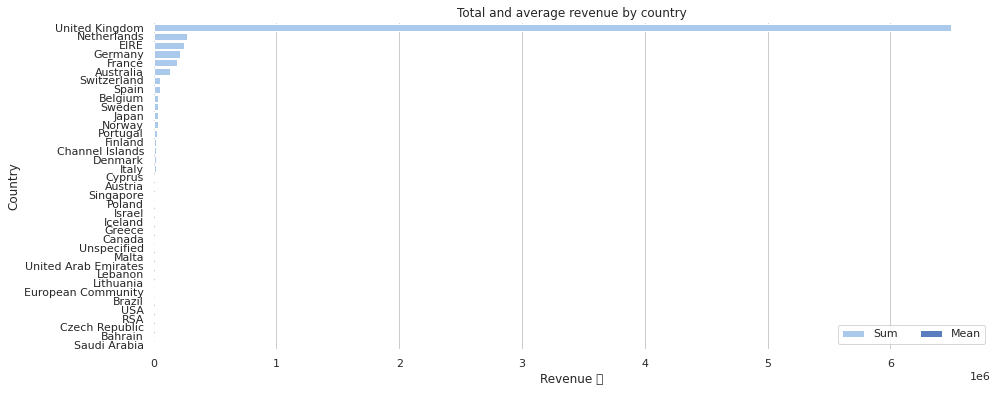

In [29]:
sns.set_theme(style = 'whitegrid')

fig, ax = plt.subplots(figsize=(15,6))

# plot total revenue by country
sns.set_color_codes('pastel')
sns.barplot(x = 'sum', y = revenue_by_country.index, data = revenue_by_country,
            label = 'Sum',color = 'b')

# plot average revenue by country
sns.set_color_codes('muted')
sns.barplot(x = 'mean', y = revenue_by_country.index, data = revenue_by_country,
            label = 'Mean', color = 'b')

ax.legend(ncol = 2, loc = 'lower right', frameon = True)
ax.set(title = 'Total and average revenue by country',ylabel = 'Country', xlabel = 'Revenue ￡')
sns.despine(left = True, bottom = True)


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 65505 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 65505 missing from current font.
  font.set_text(s, 0, flags=flags)


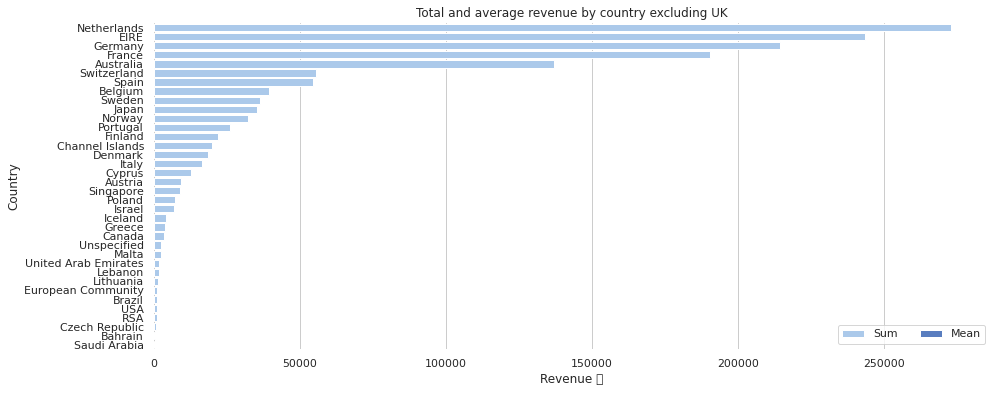

In [30]:
# plot revenue in total and on average excluding UK
revenue_by_country2 = revenue_by_country.drop('United Kingdom')
sns.set_theme(style = 'whitegrid')

fig, ax = plt.subplots(figsize=(15,6))

# plot total revenue by country excluding UK
sns.set_color_codes('pastel')
sns.barplot(x = 'sum', y = revenue_by_country2.index, data = revenue_by_country2,
            label = 'Sum',color = 'b')

# plot average revenue by country excluding UK
sns.set_color_codes('muted')
sns.barplot(x = 'mean', y = revenue_by_country2.index, data = revenue_by_country2,
            label = 'Mean', color = 'b')

ax.legend(ncol = 2, loc = 'lower right', frameon = True)
ax.set(title = 'Total and average revenue by country excluding UK',ylabel = 'Country', xlabel = 'Revenue ￡')
sns.despine(left = True, bottom = True)


In [31]:
# Plot revenues generated by countries using Choropleth Map 
# Due to the gap between UK and other countries, I remove UK for Choropleth Map
revenue_fig = px.choropleth(
    data_frame = revenue_by_country2,
    locations = revenue_by_country2.index,
    locationmode = 'country names',
    color = 'sum',
    color_continuous_scale = 'sunset',
    scope = 'world',
    title = 'Total Revenues by Country excluding UK'
)
revenue_fig.show()

                      Transaction_count
Country                                
United Kingdom                    19180
Germany                             583
France                              439
EIRE                                312
Belgium                             114
Spain                               102
Netherlands                          98
Switzerland                          71
Australia                            69
Portugal                             65
Italy                                54
Finland                              45
Sweden                               44
Norway                               37
Channel Islands                      31
Japan                                27
Poland                               24
Denmark                              20
Cyprus                               19
Austria                              18
Malta                                10
Singapore                            10
Unspecified                           8


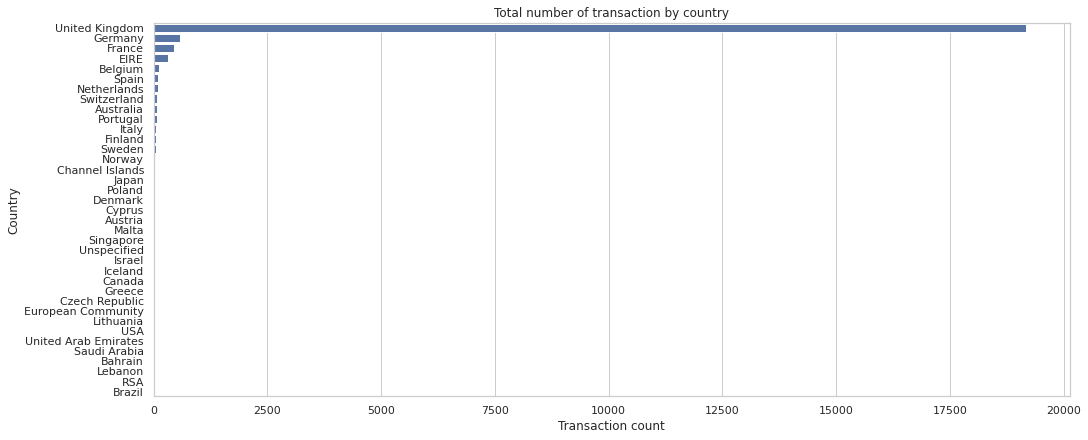

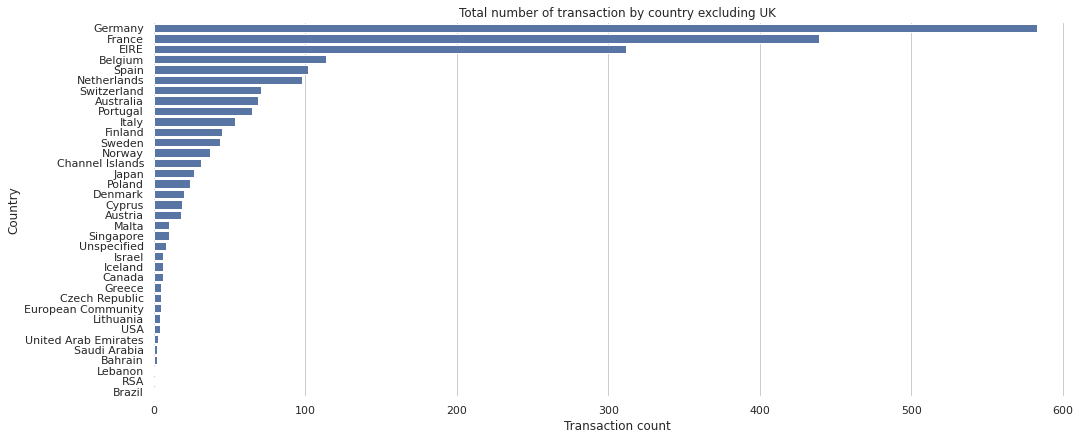

In [32]:
count_by_country = df_da.groupby(['Country'])['InvoiceNo'].unique().to_frame()
count_by_country['Transaction_count'] = count_by_country['InvoiceNo'].apply(lambda x:len(x))
count_by_country.drop(['InvoiceNo'],axis = 1,inplace=True)
count_by_country.sort_values(by = ['Transaction_count'],ascending = False, inplace = True)
print(count_by_country)

count_by_country2 = count_by_country.drop('United Kingdom')
count_by_country2.columns = ['Transaction_count']
sns.set_theme(style = 'whitegrid')

# plot number of transactions by country
fig = plt.figure(constrained_layout = True, figsize=(15,6))
sns.barplot(x = 'Transaction_count', y = count_by_country.index, data = count_by_country,color = 'b')
plt.title('Total number of transaction by country')
plt.xlabel('Transaction count')
plt.ylabel('Country')

# plot average revenue by country excluding UK
fig = plt.figure(constrained_layout = True, figsize=(15,6))
sns.barplot(x = 'Transaction_count', y = count_by_country2.index, data = count_by_country2, color = 'b')
plt.title('Total number of transaction by country excluding UK')
plt.xlabel('Transaction count')
plt.ylabel('Country')

sns.despine(left = True, bottom = True)
plt.show()

                          sum       mean  median
Country                                         
United Kingdom        3841155  11.197919     4.0
Netherlands            192170  84.100656    64.0
EIRE                   132630  18.446453    10.0
Germany                113655  12.388816    10.0
France                 106667  13.059133    10.0
Australia               83643  66.488871    24.0
Sweden                  35632  77.629630    20.0
Switzerland             29778  15.864678    12.0
Spain                   26561  10.810338     6.0
Japan                   25267  72.191429    40.0
Belgium                 22055  11.189751    10.0
Norway                  16928  16.710760    12.0
Portugal                14451  10.555880     8.0
Finland                 10535  15.379562    10.0
Channel Islands          9414  12.535286    10.0
Denmark                  8015  21.203704    12.0
Italy                    7954  10.005031     6.0
Cyprus                   6302  10.382208     6.0
Singapore           

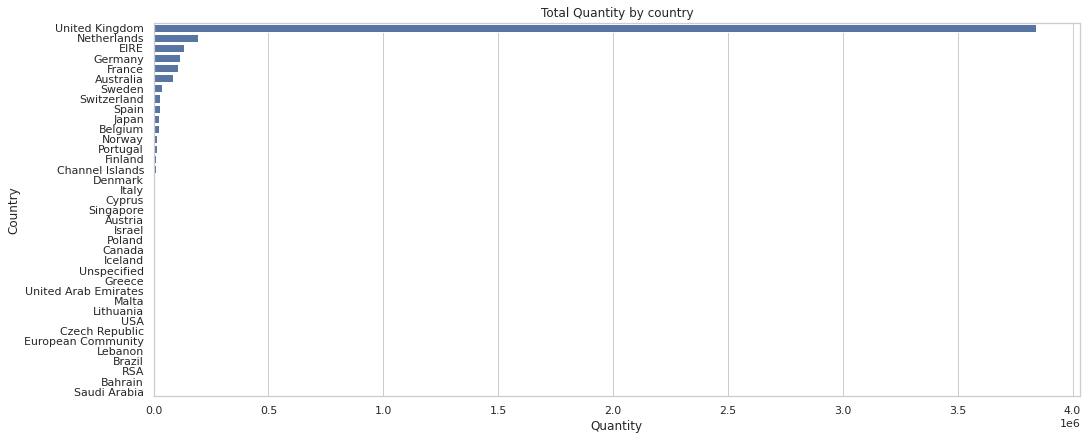

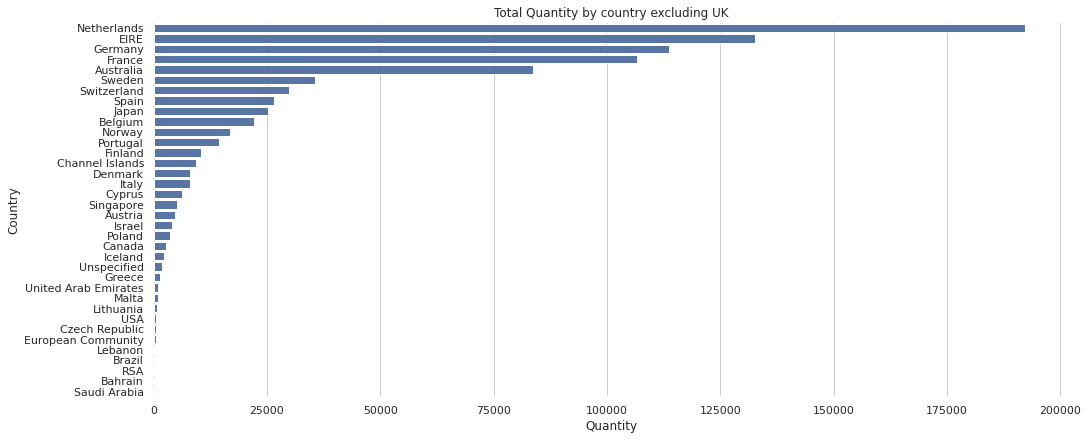

In [33]:
quantity_by_country= df_da.groupby(['Country'])['Quantity'].agg(['sum','mean','median']).sort_values(by = ['sum'],ascending = False)
print(quantity_by_country)
quantity_by_country2 = quantity_by_country.drop('United Kingdom')

sns.set_theme(style = 'whitegrid')

# plot transaction quantity by country
fig = plt.figure(constrained_layout = True, figsize=(15,6))
sns.barplot(x = 'sum', y = quantity_by_country.index, data = quantity_by_country, color = 'b')
plt.title('Total Quantity by country')
plt.xlabel('Quantity')
plt.ylabel('Country')

fig = plt.figure(constrained_layout = True, figsize=(15,6))
# plot transaction quantity by country excluding UK
sns.barplot(x = 'sum', y = quantity_by_country2.index, data = quantity_by_country2, color = 'b')
plt.title('Total Quantity by country excluding UK')
plt.xlabel('Quantity')
plt.ylabel('Country')

sns.despine(left = True, bottom = True)
plt.show()

**Question 2: Which country had the highest number of customers?**<br>

*   UK had 3918 customers which is the most customer among other countries. 
*   Germany and France came to second and third place, with 94 and 86 customers.

In [34]:
customer_by_country = df_da.groupby(['Country'])['CustomerID'].unique().to_frame()
customer_by_country['Customer_count'] = customer_by_country['CustomerID'].apply(lambda x:len(x))
customer_by_country.drop(['CustomerID'],axis = 1,inplace=True)
customer_by_country.sort_values(by = ['Customer_count'],ascending = False, inplace = True)
customer_by_country

,Customer_count
Country,
United Kingdom,3918
Germany,94
France,86
Spain,30
Belgium,25
Switzerland,21
Portugal,19
Italy,15
Finland,11


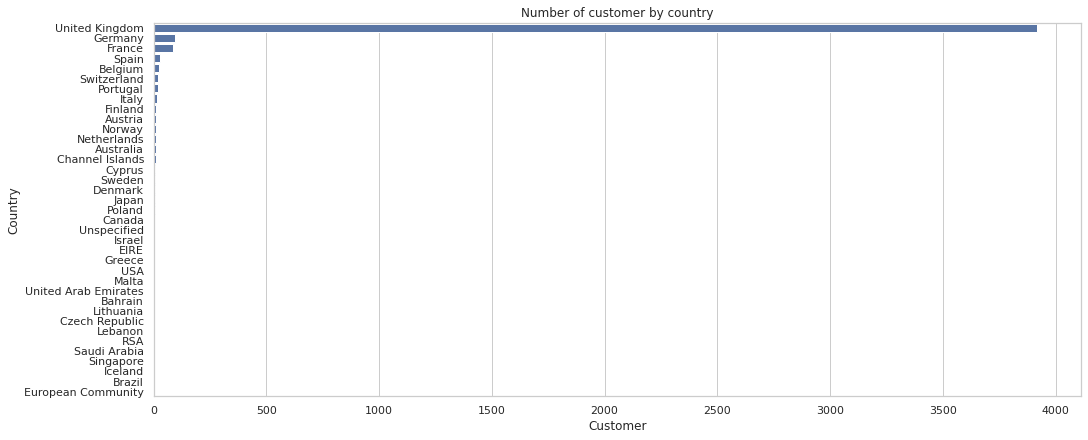

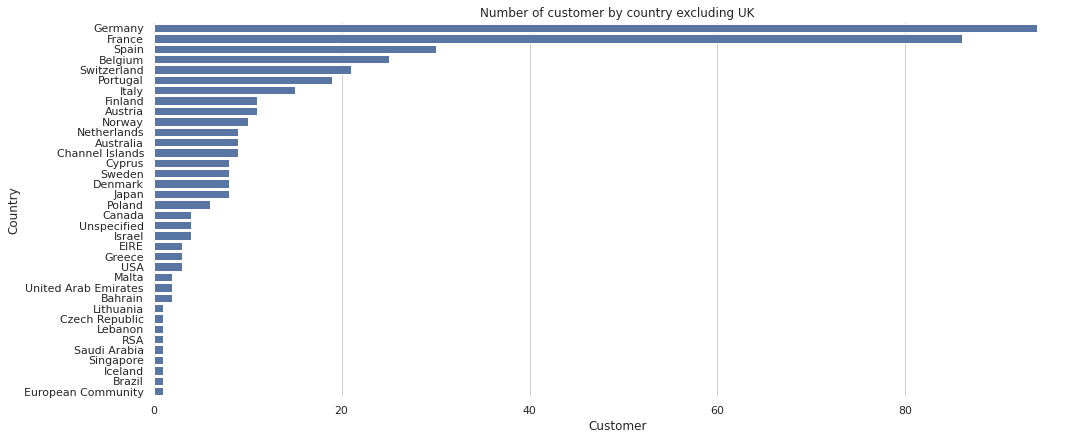

In [35]:
customer_by_country2 = customer_by_country.drop('United Kingdom')

sns.set_theme(style = 'whitegrid')

# plot number of customer by country
fig = plt.figure(constrained_layout = True, figsize=(15,6))
sns.barplot(x = 'Customer_count', y = customer_by_country.index, data = customer_by_country, color = 'b')
plt.title('Number of customer by country')
plt.xlabel('Customer')
plt.ylabel('Country')

fig = plt.figure(constrained_layout = True, figsize=(15,6))
# plot number of customer by country excluding UK
sns.barplot(x = 'Customer_count', y = customer_by_country2.index, data = customer_by_country2, color = 'b')
plt.title('Number of customer by country excluding UK')
plt.xlabel('Customer')
plt.ylabel('Country')

sns.despine(left = True, bottom = True)
plt.show()

**Question 3: Which customer(s) made the highest number of ordrs?** <br>


*   CusomterID 14911 placed the most orders, 241 orders in total. Each order may contain more than one transaction since a customer may purchase different items within one invoice.


**Question 4: Which customer(s) generated the most and the least revenue?** <br>
*   CustomerID 14646 generated the most revenue, ￡268478 and the revenue on each transaction was approximately ￡135; while CustomerID 16446 generated the least revenue, ￡2.9 in total.
*   CustomerID 14646 purchased 188957 items in total and each item had unit price ￡2.5 on average.
*   Most customers generated ￡303 to ￡1608 revenue for the company.


In [36]:
order_by_customer = df_da.groupby(['CustomerID'])['InvoiceNo'].unique().to_frame()
order_by_customer['Order_count'] = order_by_customer['InvoiceNo'].apply(lambda x:len(x))
order_by_customer.drop(['InvoiceNo'],axis = 1,inplace=True)
order_by_customer.sort_values(by = ['Order_count'],ascending = False, inplace = True)
order_by_customer.head(10)

,Order_count
CustomerID,
14911,241
12748,216
17841,166
14606,126
13089,116
15311,113
12971,88
14527,85
13408,79


In [37]:
# Using Revenue > 0 to filter out canceled orders and to keep valid orders.
revenue_by_customer = df_da[df_da['Revenue']> 0].groupby(
    ['CustomerID'])[['Revenue','Quantity','UnitPrice']].agg(
        ['sum','mean','median']).sort_values(
           by = [('Revenue','sum')], ascending = False)
revenue_by_customer.head()

Revenue                     Quantity                     \
                  sum        mean  median      sum        mean median   
CustomerID                                                              
14646       268478.00  134.913568  105.60   188957   94.953266   72.0   
18102       248171.76  608.264118  392.40    61426  150.553922  108.0   
17450       194390.79  578.544018  294.48    69973  208.252976   96.0   
14911       137409.20   25.517029   17.00    76683   14.240111   10.0   
12415       124914.53  174.950322  135.00    77374  108.366947   96.0   

           UnitPrice                   
                 sum      mean median  
CustomerID                             
14646        4974.70  2.499849   1.45  
18102        1831.96  4.490098   4.58  
17450        1135.32  3.378929   2.55  
14911       25231.58  4.685530   2.10  
12415        2097.08  2.937087   1.65

count      4299.000000
mean       1939.344086
std        8288.643218
min           2.900000
25%         303.060000
50%         653.380000
75%        1608.680000
max      268478.000000
Name: (Revenue, sum), dtype: float64


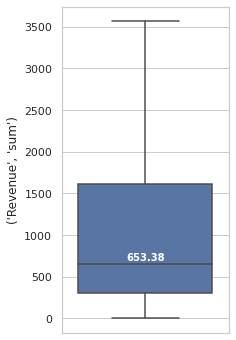

In [38]:
# display statistical summary for box plot
print(revenue_by_customer[('Revenue','sum')].describe())

# examine total revenue by customer via boxplot
sns.set_theme(style = 'whitegrid')
fig, ax = plt.subplots(figsize = (3,6))

median = round(revenue_by_customer[('Revenue','sum')].median(),3)
median_position = median*1.06

ax = sns.boxplot(y = revenue_by_customer[('Revenue','sum')], showfliers = False) # remove outliers for better visualization
ax.text(
    x = ax.get_xticks(), 
    y = median_position,
    s = median, 
    horizontalalignment = 'center', 
    size = 'small', 
    color = 'w',
    weight = 'semibold'
    )
# fig = px.box(data_frame = revenue_by_customer, x = ('Revenue','sum'))
fig.show()

**Question 5: Which customer(s) was likely cancel orders?**<br>



*   *CustomerID 15838* returned 9361 items in total but only caused ￡292.32 revenue loss.
*   *CustomerID 15749* and *16029* returned 9014 and 6476 items respectively, and caused ￡22998.40 and ￡27682.15 revenue loss to the company.
*   *CustomerID 15098* returned 61 items and caused the most revenue loss, ￡39267.



             Revenue Quantity
                 sum      sum
CustomerID                   
15098      -39267.00      -61
15838        -292.32    -9361
15749      -22998.40    -9014
16029      -27682.15    -6476
12931       -8593.15    -4627
14607       -5228.40    -3768
14911      -11252.44    -3335
17949       -5678.28    -2951
12901       -1361.44    -2160
15482       -4486.24    -2022
15769       -4429.00    -2012


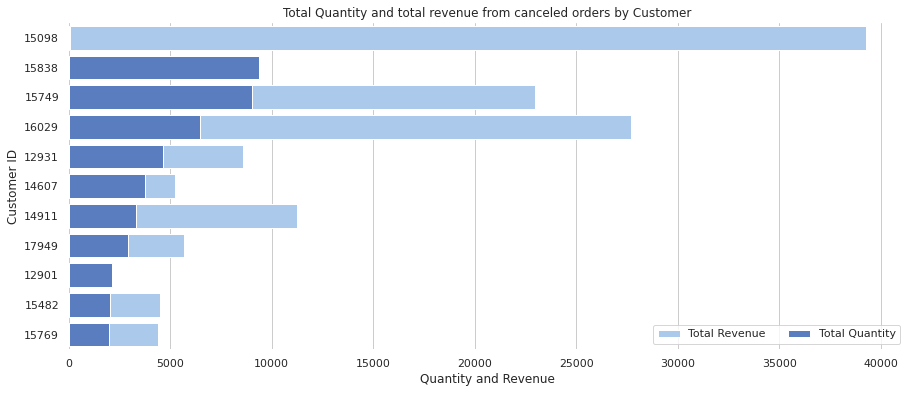

In [39]:
# retrieve top 10 customers with the most quantity returned

cancel_by_customer = df_da[df_da['Quantity'] < 0].groupby('CustomerID')[['Revenue','Quantity']].agg(
    ['sum']).sort_values(
        by=[('Quantity','sum')]).head(10)
# find the customer that causes the most revenue loss
most_revenue_loss = df_da[df_da['Quantity'] < 0].groupby('CustomerID')[['Revenue','Quantity']].agg(
    ['sum']).sort_values(
        by=[('Revenue','sum')]).head(1)
cancel_by_customer = pd.concat([most_revenue_loss,cancel_by_customer])
print(cancel_by_customer)

sns.set_theme(style = 'whitegrid')
fig, ax = plt.subplots(figsize=(15,6))

customerids = list(map(str, cancel_by_customer.index))

# plot total revenue from canceled orders by customer
sns.set_color_codes('pastel')
sns.barplot(x = abs(cancel_by_customer[('Revenue','sum')]), y = customerids, data = cancel_by_customer,
            label = 'Total Revenue',color = 'b')

# plot total quantity from canceled orders by customer
sns.set_color_codes('muted')
sns.barplot(x = abs(cancel_by_customer[('Quantity','sum')]), y = customerids, data = cancel_by_customer,
            label = 'Total Quantity', color = 'b')

ax.legend(ncol = 2, loc = 'lower right', frameon = True)
ax.set(title = 'Total Quantity and total revenue from canceled orders by Customer',ylabel = 'Customer ID', xlabel = 'Quantity and Revenue')
sns.despine(left = True, bottom = True)


**Question 6: How many returned customers were there over the year?** <br>

*   Number of returned customers had a drastic increase during Nov 2011 and number of customers overall had a similar trend.
* Ratio of returned customers in Dec 2010 and Nov 2011 were higher over the year.


In [40]:
# Since invoice number and customer ID are both repetitve, I firstly group data by invoice number
# then based on date, I group data by customer ID to eventually get number of customers including returned customers in each month.

# group data by invoice number and date
returned_customer = df_da.groupby(['InvoiceNo','InvoiceDate']).agg({
    'Revenue':'sum',
    'CustomerID':'max'
})
returned_customer.reset_index(level = ['InvoiceNo'],inplace = True) # remove invoice number from multiindex

# count number of returned customers on monthly basis
# 'M' - month end frequency
returned_customer = returned_customer.groupby(['CustomerID',pd.Grouper(freq='M')]).filter(lambda x: len(x) > 1).resample('M').nunique() #.unique().count()
returned_customer = returned_customer[['CustomerID']]
returned_customer.columns = ['Customer_Count']

# count number of customers on monthly basis
all_customer = df_da.set_index('InvoiceDate').resample('M').nunique()#.unique().count()
all_customer = all_customer[['CustomerID']]
all_customer.columns = ['Customer_Count']

# merge two table into one
monthly_customer_traffic = returned_customer.join(all_customer, lsuffix='_Returned',rsuffix = '_All')

# calculate ratio between returned and all customers on monthly basis
monthly_customer_traffic['Per_of_returned'] = monthly_customer_traffic['Customer_Count_Returned']/ monthly_customer_traffic['Customer_Count_All']
monthly_customer_traffic.reset_index(inplace=True)
# remove December 2011 since there only one day of data included in the dataset
monthly_customer_traffic.drop(monthly_customer_traffic.tail(1).index, inplace = True)
monthly_customer_traffic

,InvoiceDate,Customer_Count_Returned,Customer_Count_All,Per_of_returned
0,2010-12-31,357,948,0.376582
1,2011-01-31,255,782,0.326087
2,2011-02-28,246,798,0.308271
3,2011-03-31,323,1020,0.316667
4,2011-04-30,271,899,0.301446
5,2011-05-31,398,1079,0.368860
6,2011-06-30,333,1051,0.316841
7,2011-07-31,327,993,0.329305
8,2011-08-31,299,980,0.305102
9,2011-09-30,400,1302,0.307220


(array([734137., 734168., 734196., 734227., 734257., 734288., 734318.,
        734349., 734380., 734410., 734441., 734471.]),
 <a list of 12 Text major ticklabel objects>)

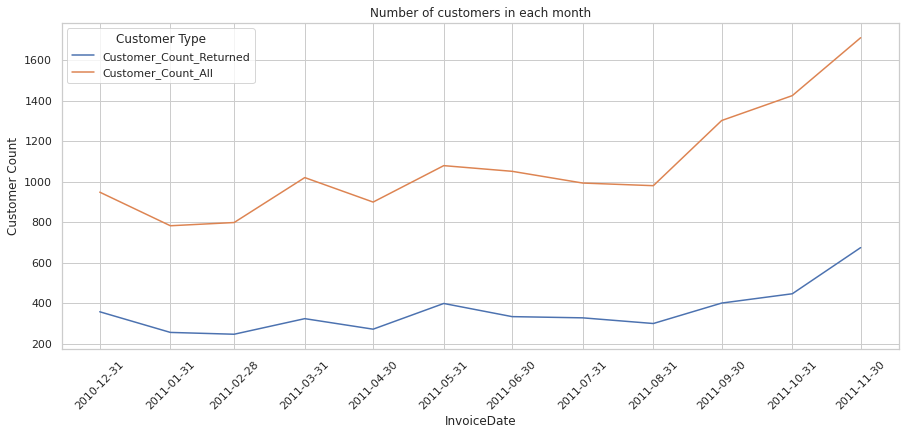

In [41]:
# plot returned and all customers
fig, ax = plt.subplots(figsize=(15,6))
sns.lineplot(data = pd.melt(monthly_customer_traffic.drop(columns = ['Per_of_returned']),['InvoiceDate'],var_name = 'Customer Type'),
             x = 'InvoiceDate',
             y = 'value',
             hue = 'Customer Type').set(
                 title = 'Number of customers in each month',
                 ylabel = 'Customer Count',
                 xticks = monthly_customer_traffic['InvoiceDate'].values
             )
plt.xticks(rotation = 45)

**Question 7.1: Which product(s) was purchased the most and least?**<br>


*   Product 84077 were the most popular product with total quantity of 543154. The product with unit proce 0.29 and 0.21 were sold 26424 and 22656 repectively, indicating that customers are willing to purchase affordable items. 
*   There are 55 products with quantity of 1. These, compared to others, were the least popular products.


There are 55 least preferred items with quantity of 1.

                       sum
StockCode UnitPrice       
22197     0.72       31381
84077     0.29       26424
          0.21       22656
84879     1.69       21413
85099B    1.79       18026
23084     1.79       17152
21212     0.55       17048
85123A    2.55       17002
22492     0.65       16440
16014     0.32       12620 
              sum
StockCode       
84077      53154
85099B     45170
22197      43986
85123A     36001
84879      34077
21212      33410
22492      25821
22616      24734
21977      24026
23084      24017


Text(0.5, 1.0, 'Top 20 the most sold produts by Stock Code')

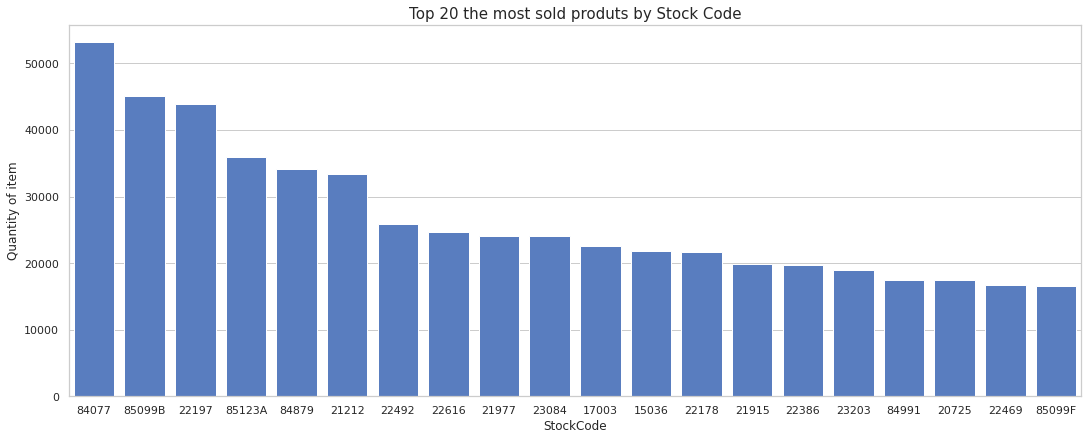

In [42]:
item_unit_price_count = df_da.groupby(['StockCode','UnitPrice'])['Quantity'].agg(['sum']).sort_values(by=['sum'],ascending = False)
item_count = df_da[df_da['Quantity']>=0].groupby(['StockCode'])['Quantity'].agg(['sum']).sort_values(by=['sum'],ascending = False)
num_least_preferred = item_count[item_count['sum'] == 1].shape[0]
print(f'There are {num_least_preferred} least preferred items with quantity of 1.\n')
print(item_unit_price_count.head(10),'\n',item_count.head(10))

# plot top 20 the most sold products
plt.figure(figsize = (15,6), constrained_layout = True)
sns.barplot(x = item_count.head(20).index, y = item_count['sum'].head(20), color = 'b').set(ylabel = 'Quantity of item')
plt.title('Top 20 the most sold produts by Stock Code', fontsize = 15)

**Question 7.2: Which product(s) was reordered by customers the most?**
*   Product 85123A, a white hangling heart t-light holder, was the most popular product and reordered 2014 times over the year.
*   There are 11 items reordered over 1000 times over the year.

In [43]:
reorder_item = df_da.groupby(['StockCode','Description'])['InvoiceNo'].count().sort_values(ascending = False).to_frame()
print('There are {} items reordered over 1000 times over the year.'.format(reorder_item[reorder_item['InvoiceNo']>=1000].shape[0]))
reorder_item.head(15)

There are 11 items reordered over 1000 times over the year.


,,InvoiceNo
StockCode,Description,
85123A,white hanging heart t-light holder,2014
22423,regency cakestand 3 tier,1852
85099B,jumbo bag red retrospot,1621
47566,party bunting,1393
84879,assorted colour bird ornament,1370
20725,lunch bag red retrospot,1313
22720,set of 3 cake tins pantry design,1197
POST,postage,1150
20727,lunch bag black skull.,1072


**Question 8: Which month sold the most and the least?**<br>
**Question 9: Which month generated the most and least revenue?**<br>


*   November generated the most revenue, over ￡1.1 million; Feburary and April generated the least revenue, approximately ￡430 thousands. 
*   There are the most items sold in November and the least in Janurary and Feburary.
*   Average revenue and average quantity did not fluctuate significantly throughout the year.
*   The overall trend of total revenue was gradual increases over time and reached a peak in November. People tend to purchase during Q4 as gifts for upcoming holiday seasons.



           Revenue            Quantity           
               sum       mean      sum       mean
Month                                            
1       473731.900  21.863204   268755  12.403314
2       435534.070  21.627474   262243  13.022296
3       578576.210  21.026901   343095  12.468927
4       425222.671  18.497593   277730  12.081521
5       647011.670  22.574637   367115  12.808869
6       606862.520  22.006909   356239  12.918444
7       573112.321  21.027015   361359  13.257962
8       615078.090  22.412115   385865  14.060086
9       929356.232  22.970321   536350  13.256630
10      973306.380  19.494199   568898  11.394368
11     1126815.070  17.542892   666813  10.381321
12      596007.230  20.868600   319759  11.196043


[Text(0, 0.5, 'Quantity'), Text(0.5, 1.0, 'Average Quantity by Month')]

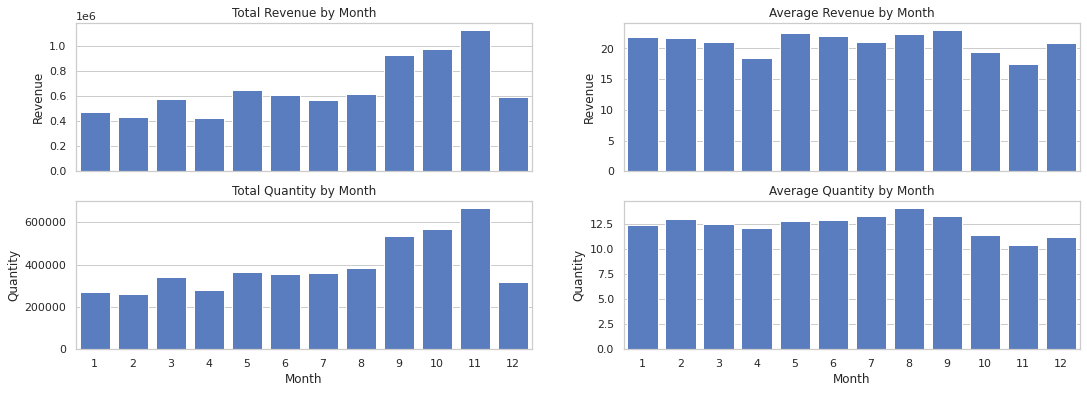

In [44]:
revenue_by_month = df_da.groupby('Month')[['Revenue','Quantity']].agg(['sum','mean'])
print(revenue_by_month)

#plot total revenue, average revenue, total quantity, average quantity in each month
fig, axes = plt.subplots(2,2,figsize = (18,6),sharex = True)

# total revenue by month
sns.barplot(x = revenue_by_month.index, y = revenue_by_month[('Revenue','sum')],color = 'b', ax = axes[0,0]).set(title = 'Total Revenue by Month', ylabel = 'Revenue', xlabel = None)
# average revenue by month
sns.barplot(x = revenue_by_month.index, y = revenue_by_month[('Revenue','mean')],color = 'b', ax = axes[0,1]).set(title = 'Average Revenue by Month', ylabel = 'Revenue', xlabel = None)
# total quantity by month
sns.barplot(x = revenue_by_month.index, y = revenue_by_month[('Quantity','sum')],color = 'b', ax = axes[1,0]).set(title = 'Total Quantity by Month', ylabel = 'Quantity')
# average quantity by month
sns.barplot(x = revenue_by_month.index, y = revenue_by_month[('Quantity','mean')],color = 'b', ax = axes[1,1]).set(title = 'Average Quantity by Month', ylabel = 'Quantity')


**Question 10: Which day of week people tend to place orders?**<br>

*   Revenue and quantity fluctutated over a week.
*   There is no order placement on Saturday specifically and sales on Sunday was lower than weekdays.



                 Revenue            Quantity           
                     sum       mean      sum       mean
Dayofweek                                              
1_Monday     1214565.191  19.477920   701379  11.247979
2_Tuesday    1519175.461  23.454200   885440  13.670104
3_Wednesday  1457572.340  21.565230   897340  13.276421
4_Thursday   1852997.310  23.452990  1088829  13.781076
5_Friday     1179068.061  22.281461   694788  13.129769
7_Sunday      757236.001  12.666410   446445   7.467758


[Text(0, 0.5, 'Quantity'), Text(0.5, 1.0, 'Average Quantity by Day of week')]

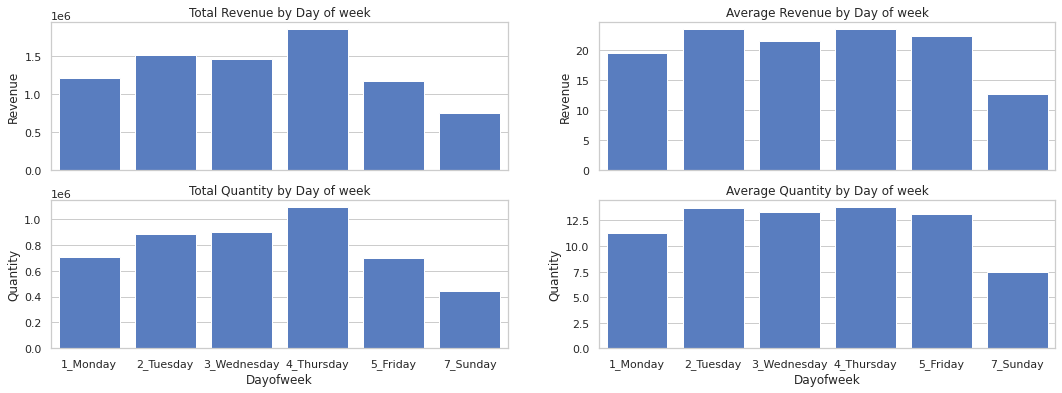

In [45]:
order_by_day = df_da.groupby(['Dayofweek'])[['Revenue','Quantity']].agg(['sum','mean'])
print(order_by_day)

#plot total revenue, average revenue, total quantity, average quantity in each day of week
fig, axes = plt.subplots(2,2,figsize = (18,6),sharex = True)
# total revenue by Day of week
sns.barplot(x = order_by_day.index, y = order_by_day[('Revenue','sum')],color = 'b', ax = axes[0,0]).set(title = 'Total Revenue by Day of week', ylabel = 'Revenue', xlabel = None)
# average revenue by Day of week
sns.barplot(x = order_by_day.index, y = order_by_day[('Revenue','mean')],color = 'b', ax = axes[0,1]).set(title = 'Average Revenue by Day of week', ylabel = 'Revenue', xlabel = None)
# total quantity by Day of week
sns.barplot(x = order_by_day.index, y = order_by_day[('Quantity','sum')],color = 'b', ax = axes[1,0]).set(title = 'Total Quantity by Day of week', ylabel = 'Quantity')
# average quantity by Day of week
sns.barplot(x = order_by_day.index, y = order_by_day[('Quantity','mean')],color = 'b', ax = axes[1,1]).set(title = 'Average Quantity by Day of week', ylabel = 'Quantity')

# RFM Customer Segmentation

RFM is used commonly in marketing and userd to analyze and determine customer value based on the recency, frequency and monetary total of transactions.<br>

---

RFM analysis consists of 3 dimensions:

1.   Recency - How recent was the customer's last pruchase?
2.   Frequency - How often did the customer make a purchase in a given period?
3.   Monetary - How much money did the customer spend in a given period?

---

Customers are segmented using K-Means based on the 3 dimensions above. More analysis on granular level will be conducted for business decision recommendataions.

---

In [46]:
recency_rank = df_da.groupby('CustomerID', as_index = False)['InvoiceDate'].max()
recency_rank['now'] = pd.to_datetime((df_da['InvoiceDate']).max())
recency_rank['Recency'] = (recency_rank['now'] - recency_rank['InvoiceDate']).astype('timedelta64[D]').astype('int64')
recency_rank.drop(['InvoiceDate','now'],axis = 1, inplace = True)
recency_rank.sort_values(by = ['Recency'], ascending = True, inplace = True)
recency_rank.reset_index(drop = True,inplace = True)
recency_rank.head()

,CustomerID,Recency
0,14853,0
1,14178,0
2,17828,0
3,15745,0
4,14146,0


In [47]:
frequency_rank = df_da.drop_duplicates(subset = ['CustomerID','InvoiceNo'], keep = 'first')
frequency_rank = frequency_rank.groupby('CustomerID', as_index = False)['InvoiceNo'].count()
frequency_rank.rename(columns = {'InvoiceNo':'Frequency'},inplace = True)
frequency_rank.sort_values(by = 'Frequency', ascending = False, inplace = True)
frequency_rank.reset_index(drop = True, inplace = True)
frequency_rank.head()

,CustomerID,Frequency
0,14911,241
1,12748,216
2,17841,166
3,14606,126
4,13089,116


In [48]:
monetary_rank = df_da.groupby('CustomerID', as_index = False)['Revenue'].sum()
monetary_rank.sort_values(by = 'Revenue',ascending = False, inplace = True)
monetary_rank.rename(columns = {'Revenue':'Monetary'}, inplace = True)
monetary_rank.reset_index(drop = True, inplace = True)
monetary_rank.head()

,CustomerID,Monetary
0,14646,267761.00
1,18102,244952.95
2,17450,187322.17
3,14911,126156.76
4,12415,123725.45


In [49]:
#https://stackoverflow.com/questions/23668427/pandas-three-way-joining-multiple-dataframes-on-columns
rfmdfs = [recency_rank, frequency_rank, monetary_rank]
rfm = reduce(lambda left, right: pd.merge(left, right, on = 'CustomerID'), rfmdfs)
rfm.set_index('CustomerID', inplace = True)
rfm.head()

,Recency,Frequency,Monetary
CustomerID,,,
14853,0,3,463.05
14178,0,7,1600.26
17828,0,9,1599.97
15745,0,6,1071.24
14146,0,6,2949.57


Use Elbow method to get the ideal number of clusters for K-means

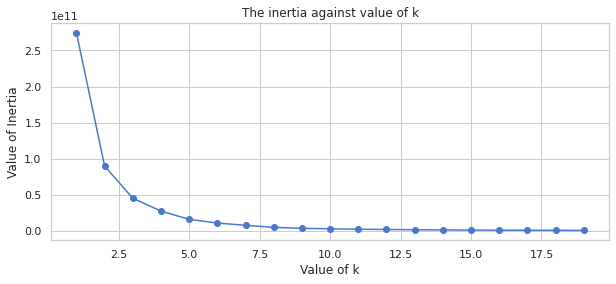

In [50]:
# use elbow method to find the best k for Kmeans
plt.figure(figsize = [10,4])

d = []
for k in range(1,20):
  kmean = KMeans(n_clusters=k)
  kmean.fit_predict(rfm)
  d.append(kmean.inertia_)

plt.plot(range(1,20),d, marker = 'o',color = 'b')
plt.xlabel('Value of k')
plt.ylabel('Value of Inertia')
plt.title('The inertia against value of k')
plt.show()

The optimal number of cluster is 3 by the Elbow method. Thus, I seek to classify customers into three tiers based on the values on recency, frequency and monetary.

In [51]:
# fitting data in Kmeans theorem
kmeans = KMeans(n_clusters = 3, random_state = 0).fit(rfm)

# creating a new column that contains cluster label for each customer
rfm['Cluster_label'] = kmeans.labels_
rfm.head()

,Recency,Frequency,Monetary,Cluster_label
CustomerID,,,,
14853,0,3,463.05,0
14178,0,7,1600.26,0
17828,0,9,1599.97,0
15745,0,6,1071.24,0
14146,0,6,2949.57,0


**FRM Analysis Observations:**

*   Recency: Cluster 0 has higher recency score while cluster 1 and 2 have much lower scores.
*   Frequency: Cluster 0 has much lower frequency score. Cluster 1 and cluster 2 have hier frequency score. Cluster 2 specifically has higher variance and cluster 1 has slightly higher median frequency score.
*   Monetary: Cluster 1 has prominent lead in monetary score compared to other clusters. Cluster 0 has the lowerst score among the three. 
*   Conclusion: 
  * **Cluster 1 is considered as Tier 1** customer with low recency score, high frequency score and high monetary score, indicating the highest customer value among others; 
  * **Cluster 2 falls into Tier 2** as it has low recency score, intermediate frequency score and intermediate monetary score;
  * **Cluter 0 is classified as Tier 3** customer with high recency score, low frequency and monetary score, indicating the lowest customer values.





[Text(0, 0.5, ''),
 Text(0.5, 0, 'Cluster'),
 Text(0.5, 1.0, 'Distribution of Monetary')]

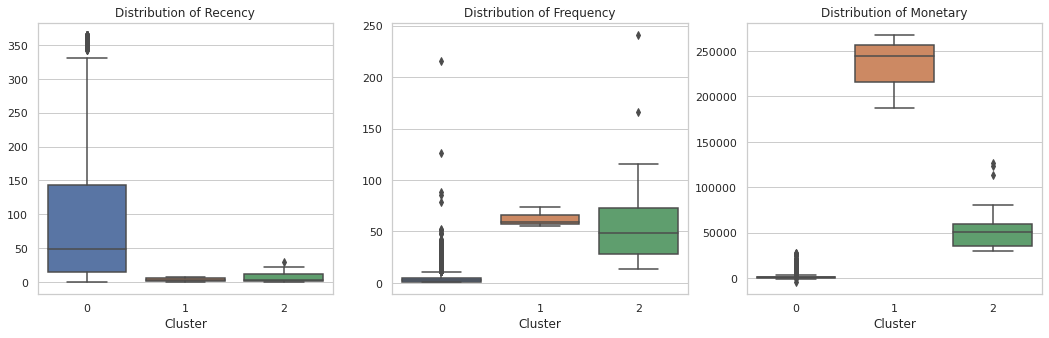

In [52]:
fig, axes = plt.subplots(ncols=3,figsize = (18,5))

# compare distribution of recency between three clusters
sns.boxplot(x = rfm['Cluster_label'], y = rfm['Recency'], ax = axes[0]).set(title = 'Distribution of Recency', ylabel = None, xlabel = 'Cluster')
# compare distribution of frequency between three clusters
sns.boxplot(x = rfm['Cluster_label'], y = rfm['Frequency'], ax = axes[1]).set(title = 'Distribution of Frequency', ylabel = None, xlabel = 'Cluster')
# compare distribution of monetary between three clusters
sns.boxplot(x = rfm['Cluster_label'], y = rfm['Monetary'], ax = axes[2]).set(title = 'Distribution of Monetary', ylabel = None, xlabel = 'Cluster')

**More RFM analysis at granular level**

In [53]:
quartile = (rfm.drop('Cluster_label', axis = 1)).quantile(q = [0.25, 0.5, 0.75])
quartile

,Recency,Frequency,Monetary
0.25,15.0,1.0,288.97
0.50,48.0,3.0,632.04
0.75,143.0,5.0,1558.72


In [54]:
# determine RFM granular tiers for each dimension based on the quartile score
# the lower Recency score, the higher the Tier is
def RScore(x):
  if x <= quartile['Recency'][0.25]:
    return 1
  elif x <= quartile['Recency'][0.50]:
    return 2
  elif x <= quartile['Recency'][0.75]:
    return 3
  else:
    return 4

# the higher Frequency score, the higher the Tier is
def FScore(x):
  if x <= quartile['Frequency'][0.25]:
    return 4
  elif x <= quartile['Frequency'][0.50]:
    return 3
  elif x <= quartile['Frequency'][0.75]:
    return 2
  else:
    return 1

# the higher Monetary score, the higher the Tier is
def MScore(x):
  if x <= quartile['Monetary'][0.25]:
    return 4
  elif x <= quartile['Monetary'][0.50]:
    return 3
  elif x <= quartile['Monetary'][0.75]:
    return 2
  else:
    return 1

In [55]:
rfm['R_Tier'] = rfm['Recency'].apply(RScore)
rfm['F_Tier'] = rfm['Frequency'].apply(FScore)
rfm['M_Tier'] = rfm['Monetary'].apply(MScore)
rfm['RFM_Tier'] = rfm[['R_Tier','F_Tier','M_Tier']].apply(lambda x:'{}{}{}'.format(x[0],x[1],x[2]), axis = 1)
rfm.head()

,Recency,Frequency,Monetary,Cluster_label,R_Tier,F_Tier,M_Tier,RFM_Tier
CustomerID,,,,,,,,
14853,0,3,463.05,0,1,3,3,133
14178,0,7,1600.26,0,1,1,1,111
17828,0,9,1599.97,0,1,1,1,111
15745,0,6,1071.24,0,1,1,2,112
14146,0,6,2949.57,0,1,1,1,111


**Observations:**
*   Best Value Customers: Purchase most recently and frequently, and spend the most .
  * No need for incentives of discount and the latest products.
*   Loyal Customers: Purchase most frequently.
  * Requires further classification using Recency and Monetary.
*   Big Spenders: Spend the most.
  * Incentives from expensive products, regular priced products in bulk and regular discount.
*   Almost Lost Customers and Lost Customers: Haven't purchased for some time, but used to purchase frequently and spend the most
  * Incentives from aggresive discounts for customer retention.
* Lost Cheap Customers: Haven't purchased for some time, and purchase infrequently, spend little.
  * Not worth customer retention.


In [56]:
print('Best Value Customers:', len(rfm.query("RFM_Tier == '111'")))
print('Loyal Customers:', len(rfm.query("F_Tier == 1")))
print('Big Spenders:', len(rfm.query("M_Tier == 1")))
print('Almost Lost:', len(rfm.query("RFM_Tier == '311'")))
print('Lost Customers:', len(rfm.query("RFM_Tier == '411'")))
print('Lost Cheap Customers:', len(rfm.query("RFM_Tier =='444'")))

Best Value Customers: 454
Loyal Customers: 1043
Big Spenders: 1083
Almost Lost: 97
Lost Customers: 14
Lost Cheap Customers: 402


# RFM Customer Segmentation - Interactive 3D Visualization

In [57]:
rfm_visual = df_da.groupby('CustomerID').agg(
    {'Quantity':'sum',
     'UnitPrice':'mean',
     'Revenue':'sum'}
)
rfm_visual.columns = ['Total_quantity','Average_unitprice','Total_revenue']
rfm_visual = rfm_visual.merge(rfm, left_index = True, right_index = True)
rfm_visual.head()

,Total_quantity,Average_unitprice,Total_revenue,Recency,Frequency,Monetary,Cluster_label,R_Tier,F_Tier,M_Tier,RFM_Tier
CustomerID,,,,,,,,,,,
12347,2266,2.734912,4085.18,31,6,4085.18,0,2,1,1,211
12348,2341,5.764839,1797.24,67,4,1797.24,0,3,2,1,321
12349,631,8.289041,1757.55,10,1,1757.55,0,1,4,1,141
12350,197,3.841176,334.40,302,1,334.40,0,4,4,3,443
12352,470,23.274737,1545.41,28,11,1545.41,0,2,1,2,212


In [58]:
fig = px.scatter_3d(
    rfm_visual, 
    x = 'Recency', 
    y = 'Frequency', 
    z = 'Monetary', 
    color = 'Cluster_label', 
    hover_data=['Total_quantity','Average_unitprice','Total_revenue','R_Tier','F_Tier','M_Tier'])
fig.show()

# Cohort Analysis

Cohort analysis is a practical tool for businesses to measure user engagement over time without the misleading effects of growth metrics. The lack of engagement of older users can be hidden by the eminent growth in number of new users. Therefore, separating user engagement metrics from growth metrics benefits businesses to understand user behaviros and improve customer retention.


Specifically, cohorts are related groups sharing common characteristics or experiences within a defined timespan. For instance, users with the same Acquisition Date belong to the same hocort.

By analyzing cohorts' activities, businesses are able to reduce the cost of retaining inactive and/or less active users before permanently losing them. In the following Cohort analysis, user activity will be measured in monthly basis.

---

In [59]:
cohort_df = df_da.copy()

In [60]:
def get_cohort_month(date):
  return dt.datetime(date.year,date.month,1)
def get_date_int(df, column):
  year = df[column].dt.year
  month = df[column].dt.month

  return year, month

In [61]:
# split transactions into months based on the invoice date
cohort_df['InvoiceMonth'] = cohort_df['Date'].apply(get_cohort_month)

# retrieve the first time a customer placed an order
cohort_df['CohortMonth'] = cohort_df.groupby('CustomerID')['InvoiceMonth'].transform('min')

# retrieve year and month of cohort date
cohort_year, cohort_month = get_date_int(cohort_df,'CohortMonth')

# calculate the differences between the first transaction and the current transaction
year_diff = cohort_df['Year'] - cohort_year
month_diff = cohort_df['Month'] - cohort_month

# measure users' activity
cohort_df['ActivityIndex'] = 1 + month_diff + year_diff * 12
cohort_df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Date,Year,Month,Day,Hour,Dayofweek,Revenue,InvoiceMonth,CohortMonth,ActivityIndex
0,536365,85123A,white hanging heart t-light holder,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,2010-12-01,2010,12,1,8,3_Wednesday,15.30,2010-12-01,2010-12-01,1
1,536365,71053,white metal lantern,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,2010-12-01,2010,12,1,8,3_Wednesday,20.34,2010-12-01,2010-12-01,1
2,536365,84406B,cream cupid hearts coat hanger,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,2010-12-01,2010,12,1,8,3_Wednesday,22.00,2010-12-01,2010-12-01,1
3,536365,84029G,knitted union flag hot water bottle,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,2010-12-01,2010,12,1,8,3_Wednesday,20.34,2010-12-01,2010-12-01,1
4,536365,84029E,red woolly hottie white heart.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,2010-12-01,2010,12,1,8,3_Wednesday,20.34,2010-12-01,2010-12-01,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
519280,580137,84347,rotating silver angels t-light hldr,1,2011-12-01 19:54:00,2.55,17566,United Kingdom,2011-12-01,2011,12,1,19,4_Thursday,2.55,2011-12-01,2011-11-01,2
519281,580137,23272,tree t-light holder willie winkie,1,2011-12-01 19:54:00,1.65,17566,United Kingdom,2011-12-01,2011,12,1,19,4_Thursday,1.65,2011-12-01,2011-11-01,2
519282,580137,23490,t-light holder hanging love bird,1,2011-12-01 19:54:00,3.75,17566,United Kingdom,2011-12-01,2011,12,1,19,4_Thursday,3.75,2011-12-01,2011-11-01,2
519283,580137,23553,landmark frame camden town,2,2011-12-01 19:54:00,12.50,17566,United Kingdom,2011-12-01,2011,12,1,19,4_Thursday,25.00,2011-12-01,2011-11-01,2


**Observations:**
*   There are 948 customers that purchase the first time in CohortMonth of 2010-12-01.
  *   There are 362 repeated customers in the following month.
  *   Acitivity of 13 indicates number of repeated customers after a year. Due to limited data in 2011-12, the value decraeses drastically.

*   There are 420 customers that purchase the first time in CohortMonth of 2011-01-01, so on.




In [62]:
activity_index = cohort_df.groupby(['CohortMonth','ActivityIndex'])['CustomerID'].nunique().reset_index()
activity_index['CohortMonth'] = activity_index['CohortMonth'].dt.date
activity_index = activity_index.pivot(index= 'CohortMonth',columns = 'ActivityIndex',values = 'CustomerID')
activity_index.fillna('')

ActivityIndex,1,2,3,4,5,6,7,8,9,10,11,12,13
CohortMonth,,,,,,,,,,,,,
2010-12-01,948.0,362.0,317.0,367.0,341.0,376.0,360.0,336.0,336.0,374.0,354.0,474.0,64.0
2011-01-01,420.0,101.0,119.0,102.0,138.0,126.0,110.0,108.0,131.0,146.0,155.0,15.0,
2011-02-01,380.0,94.0,73.0,106.0,102.0,94.0,97.0,107.0,98.0,119.0,11.0,,
2011-03-01,440.0,84.0,112.0,96.0,102.0,78.0,116.0,105.0,127.0,6.0,,,
2011-04-01,299.0,68.0,66.0,63.0,62.0,71.0,69.0,78.0,7.0,,,,
2011-05-01,279.0,66.0,48.0,48.0,60.0,68.0,74.0,8.0,,,,,
2011-06-01,235.0,49.0,44.0,64.0,58.0,79.0,5.0,,,,,,
2011-07-01,191.0,40.0,39.0,44.0,52.0,1.0,,,,,,,
2011-08-01,167.0,42.0,42.0,42.0,3.0,,,,,,,,


**Retention Rate & Heat Map**

In [63]:
retention_rate = activity_index.divide(activity_index[1], axis = 0)
retention_rate.round(2) * 100

ActivityIndex,1,2,3,4,5,6,7,8,9,10,11,12,13
CohortMonth,,,,,,,,,,,,,
2010-12-01,100.0,38.0,33.0,39.0,36.0,40.0,38.0,35.0,35.0,39.0,37.0,50.0,7.0
2011-01-01,100.0,24.0,28.0,24.0,33.0,30.0,26.0,26.0,31.0,35.0,37.0,4.0,NaN
2011-02-01,100.0,25.0,19.0,28.0,27.0,25.0,26.0,28.0,26.0,31.0,3.0,NaN,NaN
2011-03-01,100.0,19.0,25.0,22.0,23.0,18.0,26.0,24.0,29.0,1.0,NaN,NaN,NaN
2011-04-01,100.0,23.0,22.0,21.0,21.0,24.0,23.0,26.0,2.0,NaN,NaN,NaN,NaN
2011-05-01,100.0,24.0,17.0,17.0,22.0,24.0,27.0,3.0,NaN,NaN,NaN,NaN,NaN
2011-06-01,100.0,21.0,19.0,27.0,25.0,34.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-01,100.0,21.0,20.0,23.0,27.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,100.0,25.0,25.0,25.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


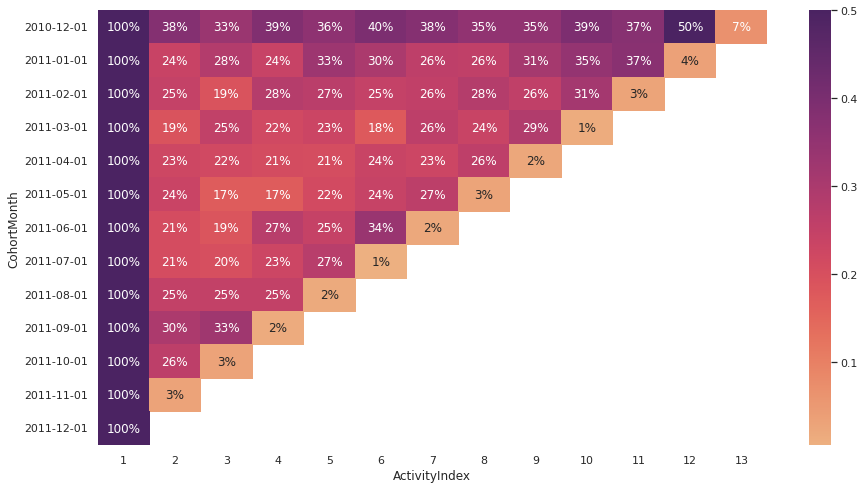

In [64]:
# plotting heatmap
plt.figure(figsize = (15,8))
sns.heatmap(data = retention_rate,
            annot = True,
            vmax = 0.5,
            fmt = '.0%',
            cmap = 'flare')
plt.show()

# Market Basket Analysis

Market Basket analysis is a useful tool for retailers to explore association between products. Apriori algorithm will be applied to extract frequent itemsets. Association rule, the core of market basket analysis, is widely used to analyze transaction data and used in recommondation system for similar products. Therefore, utilizing association rule in business analytics helps businesses promote similar products to customers and yield higher revenues.

Three criteria in Association Rules:
1. Support: indicating how frequently the items appear in the data.
2. Confidence: indicating the number of IF-THEN statements are found true. For instance, purchase egg(IF) - purchase butter(THEN).
3. Lift: comparing confidence with expected confidence.<br>

Examples of calculation processes can be found [here](https://www.saedsayad.com/association_rules.htm).

---

There are 100 transaction records randomly picked since:

1.   There is computation limitation on my local machine.
2.   There is **Spurious Correlation** that substantially influences our estimation on correlations.
  1. https://hbr.org/2015/06/beware-spurious-correlations
  2. https://www.investopedia.com/terms/s/spurious_correlation.asp

---

More on Spurious Correlation:<br>
On e-commerce platforms, a large number of products is present in a single basket and there is even larger number of baskets overall. This reults in a "Sparse Matrix" containing mostly 0s, causing lower support values of basket occurance.

---

In [65]:
basket_df = df_da.sample(100, random_state = 0)
basket = basket_df[['InvoiceNo','Description']]
basket.set_index('InvoiceNo',inplace = True)
basket = pd.get_dummies(basket)
basket_sets = pd.pivot_table(basket, index = 'InvoiceNo', aggfunc = 'sum')
basket_sets.head()

,Description_advent calendar gingham sack,Description_airline bag vintage jet set red,Description_alarm clock bakelike red,Description_aluminium stamped heart,Description_black christmas tree 120cm,Description_brown pirate treasure chest,Description_caravan square tissue box,Description_card christmas village,Description_card dolly girl,Description_card psychedelic apples,...,Description_travel card wallet vintage ticket,Description_treasure tin gymkhana design,Description_vintage union jack bunting,Description_white wire egg holder,Description_wood black board ant white finish,Description_wooden happy birthday garland,Description_woodland charlotte bag,Description_woodland design cotton tote bag,Description_world war 2 gliders asstd designs,Description_zinc metal heart decoration
InvoiceNo,,,,,,,,,,,,,,,,,,,,,
536778,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
537144,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
537624,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
538630,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
539716,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [66]:
# apply Apriori algorithm to find frequent itemsets
frequent_itemsets = apriori(basket_sets, min_support = 0.01, use_colnames = True)
frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))

print("There are {} frequent itemsets present in the sample.\n".format(len(frequent_itemsets)))

# Advanced and strategical data frequent set selection
frequent_itemsets[ (frequent_itemsets['length'] > 1) &
                   (frequent_itemsets['support'] >= 0.01) ]

There are 95 frequent itemsets present in the sample.



,support,itemsets,length
94,0.010101,"(Description_pack of 12 skull tissues, Descrip...",2


In [67]:
frequent_itemsets.head()

,support,itemsets,length
0,0.010101,(Description_advent calendar gingham sack),1
1,0.010101,(Description_airline bag vintage jet set red),1
2,0.010101,(Description_alarm clock bakelike red ),1
3,0.020202,(Description_aluminium stamped heart),1
4,0.010101,(Description_black christmas tree 120cm),1


In [68]:
# generating the association rules
rules = association_rules(frequent_itemsets, metric = 'lift', min_threshold = 1)
rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']]

,antecedents,consequents,support,confidence,lift
0,(Description_pack of 12 skull tissues),(Description_white wire egg holder),0.010101,1.0,99.0
1,(Description_white wire egg holder),(Description_pack of 12 skull tissues),0.010101,1.0,99.0


**Observations:**
*   There are 94 distinct product descriptions from 100 transaction records, resulting in a Sparse Matrix.
*   Low frequency of itemsets causes lower support value and there only 1 frequent itemset with length of 2, meaning it is a complete IF-THEN statement.
*   The confidence from the result of Association rule is 1, indicating that the presence of white wire egg holder MUST couple with the presence of pack-of-12 skull tissues. There seems to be a causal relationship, however, the frequency of presence for either single product or combination of two products is merely 1, which leads to Spurious Correlation. Such spurious causal relationship between two products is generally caused by an inapparent third factor.

# Revenue Predidction

In the last section of the project, I am going to explore and test several machine learning algorithms for revenue predcition. Factors that affect revenues generated by a single customer are summarized as following:
1. Number of transanctions per customer
2. Average unit price per customer
3. Total number of items per customer
4. Days as a customer
5. Days since last purchase
6. Order frequency

Predicting customer revenue will use following regression algortihms for training and testing:
  1. Random Forest
  4. Linear regresssion (Lasso, Ridge, ElasticNet)
  3. Grandient Boosting and Extreme Gradient Boosting

## Regression modeling

**Data preprocessing** 

In [69]:
df_model = df.copy()

In [70]:
df_predictor = df_model.groupby('CustomerID').agg(
    {'InvoiceNo':'count', # number of orders per customer
     'UnitPrice':'mean', # average unit price per customer
     'Revenue':'sum', # total revenue per customer
     'Quantity':'sum', # total number of items per customer
     }
)
df_predictor.head()

,InvoiceNo,UnitPrice,Revenue,Quantity
CustomerID,,,,
12347,171,2.734912,4085.18,2266
12348,31,5.764839,1797.24,2341
12349,73,8.289041,1757.55,631
12350,17,3.841176,334.40,197
12352,95,23.274737,1545.41,470


In [71]:
days_as_customer = df_model.groupby('CustomerID')['InvoiceDate'].min().to_frame() # the date of the first order made by customer
days_as_customer['lastday'] = df_model['InvoiceDate'].max()
days_as_customer['days_as_customer'] = (days_as_customer['lastday'] - days_as_customer['InvoiceDate']).dt.days + 1
days_as_customer.drop(['InvoiceDate','lastday'],axis = 1, inplace = True)
days_as_customer

,days_as_customer
CustomerID,
12347,360
12348,351
12349,11
12350,303
12352,289
...,...
18280,270
18281,173
18282,119


In [72]:
last_purchase = df_model.groupby('CustomerID')['InvoiceDate'].max().to_frame() # the date of the last order made by customer
last_purchase['lastday'] = df_model['InvoiceDate'].max()
last_purchase['days_since_last_purchase'] = (last_purchase['lastday'] - last_purchase['InvoiceDate']).dt.days + 1
last_purchase.drop(['InvoiceDate','lastday'],axis = 1, inplace = True)
last_purchase

,days_since_last_purchase
CustomerID,
12347,32
12348,68
12349,11
12350,303
12352,29
...,...
18280,270
18281,173
18282,115


**Correlation between predictors**

In [73]:
predictordfs = [df_predictor, days_as_customer, last_purchase]
df_predictors = reduce(lambda left,right: pd.merge(left,right, on = 'CustomerID'), predictordfs)
df_predictors.rename({
    'InvoiceNo':'number_of_orders',
    'UnitPrce':'average_unit_price',
    'Quantity':'number_of_items'
}, axis = 1,inplace = True)
df_predictors['order_frequency'] = df_predictors['number_of_orders'] / df_predictors['days_as_customer']
#df_predictors.reset_index(level = 'CustomerID', inplace = True)
df_predictors.head()

,number_of_orders,UnitPrice,Revenue,number_of_items,days_as_customer,days_since_last_purchase,order_frequency
CustomerID,,,,,,,
12347,171,2.734912,4085.18,2266,360,32,0.475000
12348,31,5.764839,1797.24,2341,351,68,0.088319
12349,73,8.289041,1757.55,631,11,11,6.636364
12350,17,3.841176,334.40,197,303,303,0.056106
12352,95,23.274737,1545.41,470,289,29,0.328720


Revenue                     1.000000
number_of_items             0.919938
number_of_orders            0.501901
days_as_customer            0.249708
order_frequency             0.092033
UnitPrice                   0.008089
days_since_last_purchase   -0.217886
Name: Revenue, dtype: float64


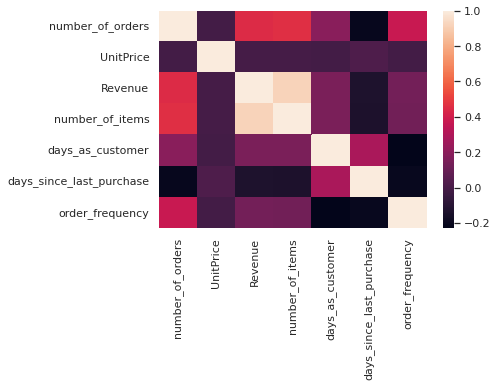

In [74]:
# remove outliers that severely affect modeling
df_predictors_trim = df_predictors[
           (df_predictors['number_of_orders'] < 1500) &
           (df_predictors['UnitPrice'] < 900) & 
           (df_predictors['number_of_items'] < 75000) &
           (df_predictors['order_frequency'] < 20) &
           (df_predictors['Revenue'] < 100000) 
           ]
print(df_predictors_trim.corr()['Revenue'].sort_values(ascending = False))
sns.heatmap(df_predictors.corr())

**Distribution of predictors**

number_of_orders             3.950414
UnitPrice                   30.171373
number_of_items             12.341255
days_as_customer            -0.394968
days_since_last_purchase     1.214605
order_frequency              7.571973
dtype: float64


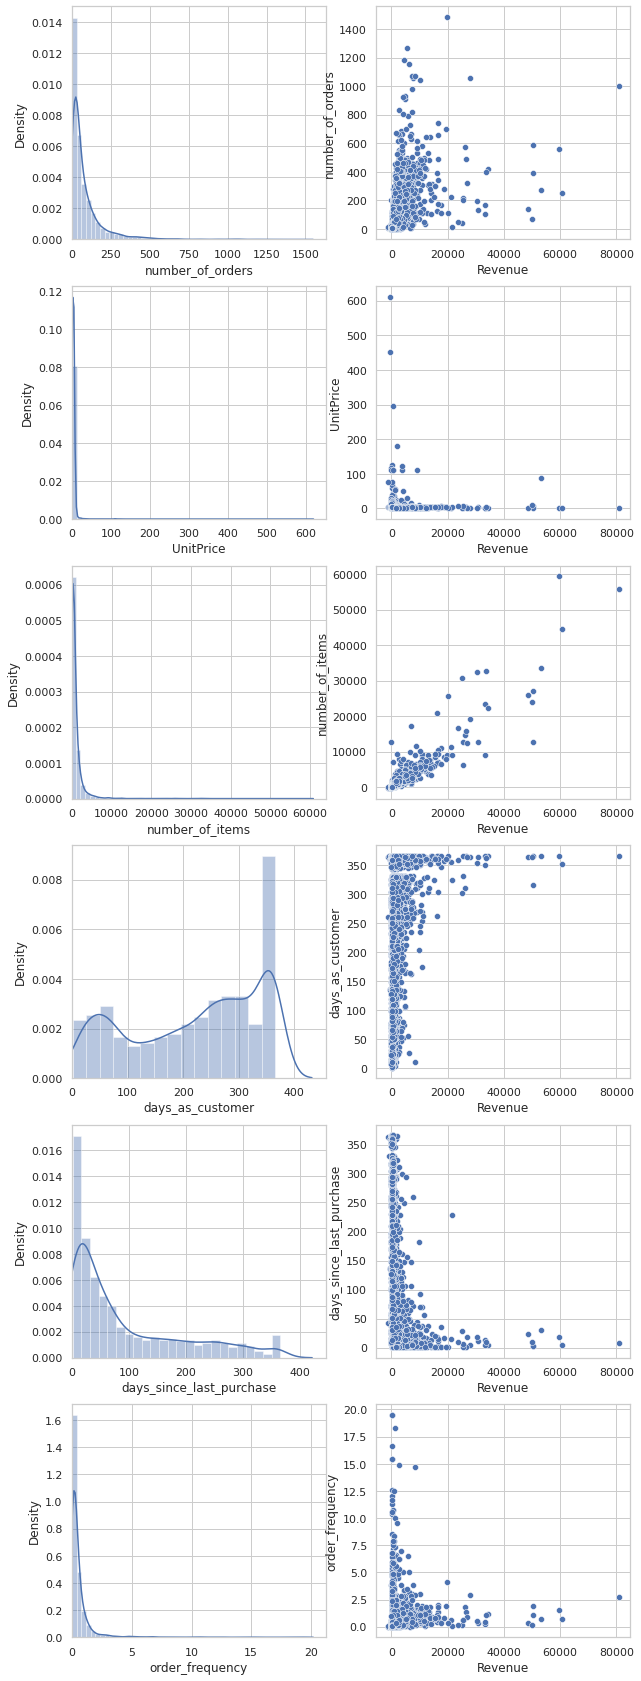

In [88]:
# define predictors and output vairable
x = df_predictors_trim.drop(['Revenue'], axis = 1)
y = df_predictors_trim['Revenue']

print(x.skew())

fig, axes = plt.subplots(nrows = 6, ncols = 2, figsize = (10,30))
row_num = 0
for col in x.columns:
  sns.distplot(x[col], ax = axes[row_num][0]).set(xlim = 0)
  sns.scatterplot(data = df_predictors_trim, x = 'Revenue', y = df_predictors_trim[col], ax = axes[row_num][1])
  row_num += 1

As shown above, all predictors are highly skewed except days_as_customer. However, due to the mist of linear relationship between some predictors and revenue, I do not apply transfomraiton and scaling to predictors. Any additional transformation and scaling will decrease score of R2 drastically, which hinders modeling.

**Modeling using Pipeline**

In [76]:
# split input and output into training and testing sets
x_train,x_test,y_train,y_test = train_test_split(x,y, test_size = 0.33, random_state = 12)

In [77]:
pipelines = {
    'RandomForest':make_pipeline(RandomForestRegressor(random_state = 12)),
    'Lasso':make_pipeline(Lasso(random_state = 12)),
    'Ridge':make_pipeline(Ridge(random_state = 12)),
    'ElasticNet':make_pipeline(ElasticNet(random_state = 12)),
    'GradientBoost':make_pipeline(GradientBoostingRegressor(random_state = 12)),
    'XGBoost':make_pipeline(XGBRegressor(objective ='reg:squarederror',random_state = 12)), # https://github.com/dmlc/xgboost/issues/4599
}

**Fine Tuning Hyperparameters using GridSearchCV**

In [78]:
#Establish all the hyperparameters in a dictionary that are going to be tested on the training sets

hyperparameters = {
    
'RandomForest' : {
     'randomforestregressor__n_estimators' : [50, 100, 150, 200, 300],
     'randomforestregressor__min_samples_leaf' : [1, 3, 5],
     'randomforestregressor__max_depth' : [3, 5, 10, 15],    
    },

'Lasso' : {
     'lasso__alpha' : [0.01, 0.06, 0.1, 0.3, 0.6, 1, 3, 6, 10,12,15]
    },    

'Ridge' : {
     'ridge__alpha' : [0.005, 0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6, 10]
    },
    
'ElasticNet' : { 
    'elasticnet__alpha': [0.001, 0.005, 0.01, 0.05, 0.1, 1, 5, 10], 
    'elasticnet__l1_ratio' : [0.1, 0.3, 0.5, 0.7, 0.9]
    },

'GradientBoost' : {
    'gradientboostingregressor__n_estimators' : [50, 100, 150, 200, 300],
    'gradientboostingregressor__learning_rate' : [0.05, 0.1, 0.15, 0.3],
    'gradientboostingregressor__max_depth' : [3, 6, 10, 15]
    },

'XGBoost' : {
    'xgbregressor__n_estimators' : [50, 100, 150, 200, 300],
    'xgbregressor__learning_rate' : [0.05, 0.1, 0.15, 0.3],
    'xgbregressor__max_depth' : [3, 5, 10, 15]
    }
}

In [79]:
# create a dictionary which will hold the model name and its best performing hyperparameters
best_fit_models = {}

# grid search each model's hyperparameters with 5 fold cross validation
# https://scikit-learn.org/stable/modules/model_evaluation.html
for name, pipeline in pipelines.items():
  model = GridSearchCV(pipeline, hyperparameters[name], cv = 5)
  model.fit(x_train, y_train)
  best_fit_models[name] = model

In [86]:
def performance_checker(model_name,y_test, pred):
  print(model_name)
  print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, pred)))
  print('R2 Score:',r2_score(y_test,pred))
  print('Mean Absolute Percent Error:', mean_absolute_percentage_error(y_test,pred))
  print('The best performing parameters:', str(model.best_params_))
  print('\n')

for name, model in best_fit_models.items():
  pred = model.predict(x_test)
  performance_checker(name, y_test, pred)


RandomForest
Root Mean Squared Error: 1625.9663284312799
R2 Score: 0.8485154613030336
Mean Absolute Percent Error: 15618848068523.75
The best performing parameters: {'randomforestregressor__max_depth': 15, 'randomforestregressor__min_samples_leaf': 3, 'randomforestregressor__n_estimators': 300}


Lasso
Root Mean Squared Error: 1611.1335010272135
R2 Score: 0.8512666808568611
Mean Absolute Percent Error: 122711385629379.56
The best performing parameters: {'lasso__alpha': 15}


Ridge
Root Mean Squared Error: 1611.1361029076359
R2 Score: 0.851266200466349
Mean Absolute Percent Error: 93635797403370.78
The best performing parameters: {'ridge__alpha': 10}


ElasticNet
Root Mean Squared Error: 1611.1261061961027
R2 Score: 0.8512680461754406
Mean Absolute Percent Error: 121525598265098.83
The best performing parameters: {'elasticnet__alpha': 10, 'elasticnet__l1_ratio': 0.1}


GradientBoost
Root Mean Squared Error: 1387.8254661614756
R2 Score: 0.8896391801453779
Mean Absolute Percent Error: 494

**Gradient Boosting Modeling and Testing**<br>
Based on the results above, GradientBoosting has the best performance among other algorithms. Thus I will proceed with gradient boosting as the targeted model for revenue prediction.

20 samples from Gradient boosting predicted results will be visulized for examining.

---

**Observation:**
* The resulted R2 score of this model in training is high, meaning the model is able to explain over 99% of the data.
* According to the coeffcient of model in both train set and test set and the line graph shown below, there is overfitting present in the model to some extent.
* The feature importances suggest **number of items** contributs most or has higher effect to the model, while **days since last purchase** has the least influences.

In [81]:
gb_reg = GradientBoostingRegressor(learning_rate = 0.1,
                                   max_depth = 3,
                                   n_estimators = 150)
gb_reg.fit(x_train,y_train)
gb_pred = gb_reg.predict(x_test)

results = pd.DataFrame({'Actual Revenues':y_test,'Predicted Revenues':gb_pred})
results.reset_index(drop = False, inplace = True)
results_visual = results.sample(20, random_state = 12)
results_visual = pd.melt(results_visual, id_vars = 'CustomerID', value_vars = ['Actual Revenues','Predicted Revenues'], var_name = 'Revenue Type', value_name = 'Revenue')

print('The coefficient of determiantion of the prediction (R2 score) on train set is ', gb_reg.score(x_train,y_train))
print('The coefficient of determiantion of the prediction (R2 score) on test set is ', gb_reg.score(x_test,y_test), '\n')

The coefficient of determiantion of the prediction (R2 score) on train set is  0.9881662366989535
The coefficient of determiantion of the prediction (R2 score) on test set is  0.889155022376112 



                          Importance
number_of_items             0.894652
UnitPrice                   0.045849
number_of_orders            0.029701
order_frequency             0.016039
days_as_customer            0.009588
days_since_last_purchase    0.004172


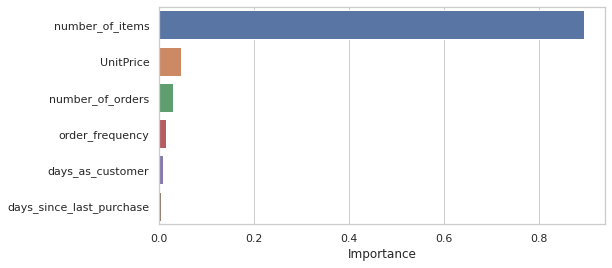

In [82]:
# examine the features importance in the model
gb_importance = pd.DataFrame(gb_reg.feature_importances_, x_train.columns)
gb_importance.columns = ['Importance']
gb_importance.sort_values(by = ['Importance'], ascending = False, inplace = True)
print(gb_importance)

fig, ax = plt.subplots(figsize = (8,4))
sns.barplot(data = gb_importance, x = 'Importance', y = gb_importance.index)

**Business recommendation**
* Number of items has determinant effect on revenue generated by a customer. To pursue the maxmization of revenue, the e-commerce company should try marketing campaigns that aim to increase number of items while slightly decreasing or maintaining unit price.

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]), <a list of 20 Text major ticklabel objects>)

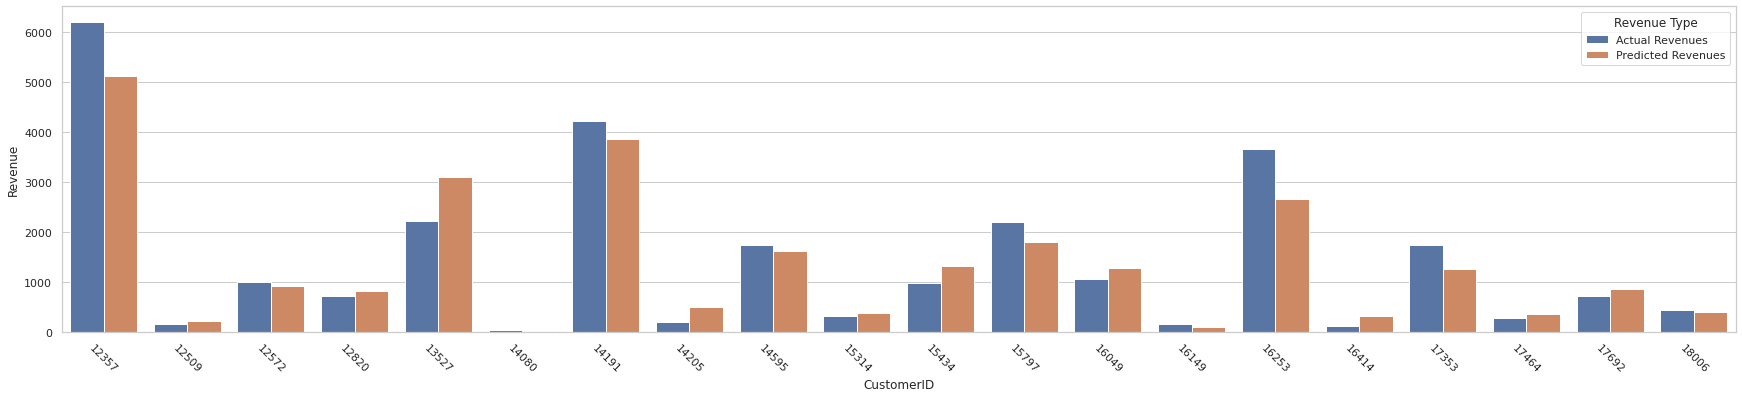

In [83]:
# visualize 20 smaple from gradient boosting predicted results
plt.figure(figsize = (30,6))
sns.barplot(data = results_visual, x = 'CustomerID', y = 'Revenue', hue = 'Revenue Type')
# for container in ax.containers:
#   ax.bar_label(container)
plt.xticks(rotation = -45)